In [1]:
import torch
from torch import optim
import matplotlib.pyplot as plt
import numpy as np

import imp
import time
import utils.movie_readin as mru
import utils.plotutils as plu
import utils.model as mod
from torch.autograd import Variable


In [23]:
imp.reload(mru)
imp.reload(mod)
#movie parameters
#movie = 'full_ocean'
#movie = 'ocean_control'
#movie = 'ocean_overlay'
#movie = 'willows_control'
movie = 'full_yellow_flowers'

if(movie == 'full_ocean'):
    movie_dirpath = '/home/vasha/research/datasets/stationary_motion/pixel2xlmomentlens/full_framerate/'
    movie_name = 'ocean_only_120.mp4_120fps.mp4'

elif(movie == 'full_reeds'):
    movie_dirpath = '/home/vasha/research/datasets/stationary_motion/pixel2xlmomentlens/full_framerate/'
    movie_name = 'ocean_only_120.mp4_120fps.mp4'
    
elif(movie == 'full_yellow_flowers'):
    movie_dirpath = '/home/vasha/research/datasets/stationary_motion/pixel2xlmomentlens/full_framerate/'
    movie_name = 'yellow_flowers_120.mp4_120fps.mp4'

elif(movie =='ocean_control'):
    movie_dirpath = '/home/vasha/research/datasets/eyetrace_overlay/'
    movie_name = 'ocean_movie_control_overlay.mp4'

elif(movie =='ocean_overlay'):
    movie_dirpath = '/home/vasha/research/datasets/eyetrace_overlay/'
    movie_name = 'ocean_movie_trace_overlay.mp4'

elif(movie =='willows_control'):
    movie_dirpath = '/home/vasha/research/datasets/eyetrace_overlay/'
    movie_name = 'willows_movie_control_overlay.mp4'   
    

movie_filepath = movie_dirpath + movie_name
#edge size of a patch
pixel_patchsize = 16
#number of frames in a patch
frame_patchsize = 480
maxframes = 512
savefolder = './output/actv_'
# read in the movie
#willows = mru.get_movie(movie_filepath, pixel_patchsize, frame_patchsize,
#                          normalize_patch=False, normalize_movie=True, encoding='mp4')
# plot a test movie
#test = willows[10,0,:,:]
#plt.imshow(test)

# hyperparameters
num_epochs = 500
batch_sizes = [200]
learning_rates = [5e-6]
learning_momentum = 0.9
#N_TEST_IMG = 5
lambda_activation = 0
lambda_biophysical = 0

# model parameters
conv_width = 12
hidden_nodes = 72
compression = pixel_patchsize**2 / hidden_nodes
#compression = 6
#hidden_nodes = pixel_patchsize**2 // compression
print(f'Model:{pixel_patchsize}^2 pixels by {frame_patchsize} frames, to {hidden_nodes} hidden nodes for {compression}x compression')

try:
    movie_dataset
except NameError:    
    movie_dataset = mru.NaturalMovieDataset(movie_filepath, pixel_patchsize, frame_patchsize, maxframes,
                              normalize_patch=True, normalize_movie=False, encoding='mp4')

print(f'Dataset Ready. {len(movie_dataset)} movie patches each of  {frame_patchsize}^2 pixel frames')


Model:16^2 pixels by 480 frames, to 72 hidden nodes for 3.5555555555555554x compression
Dataset Ready. 4510 movie patches each of  480^2 pixel frames


Learning Rate:5e-06; batch size:200
Training 500 Epochs. Estimated run time: 42.6mins.
************************************************Epoch 50/500 (mean time per epoch: 3.0s)


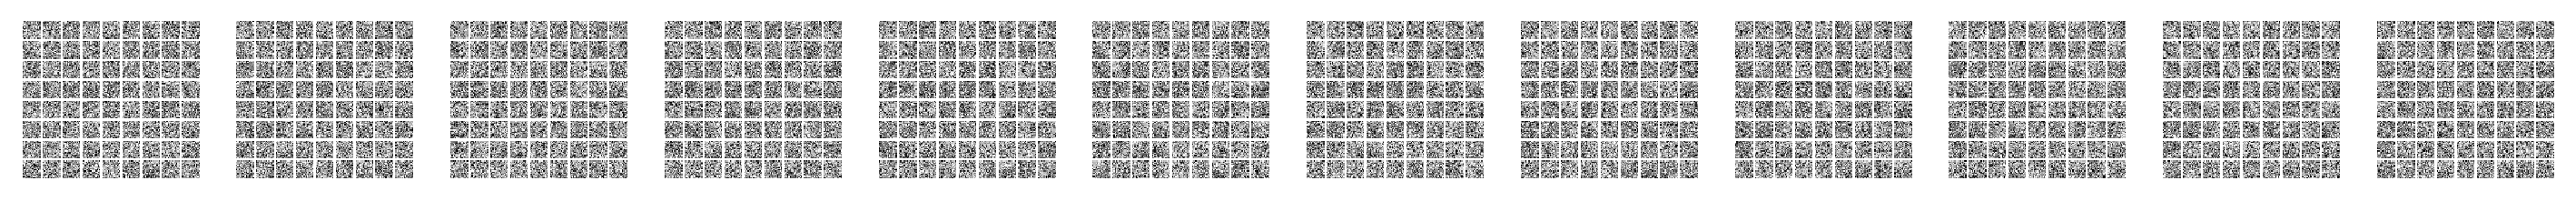

*************************************************Epoch 100/500 (mean time per epoch: 3.0s)


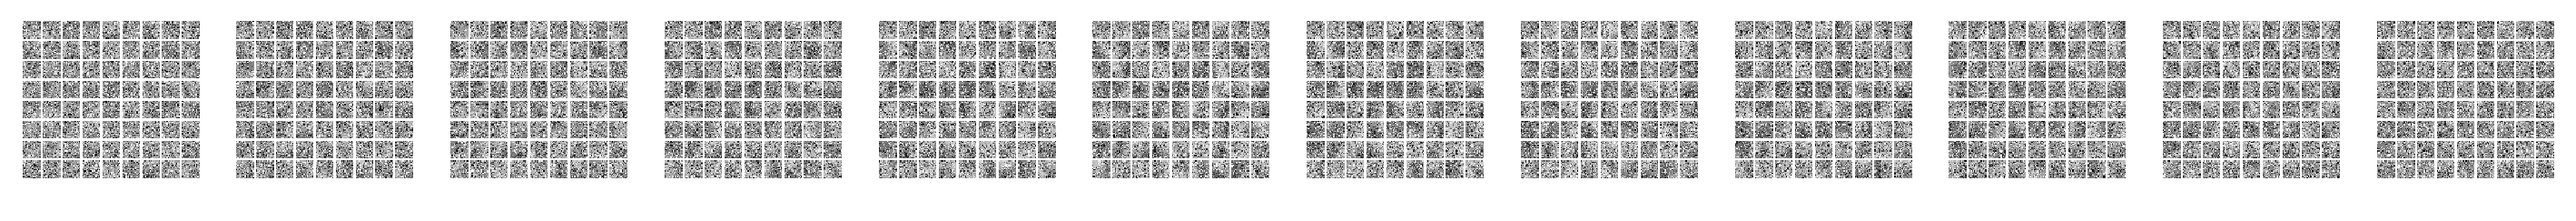

*************************************************Epoch 150/500 (mean time per epoch: 3.0s)


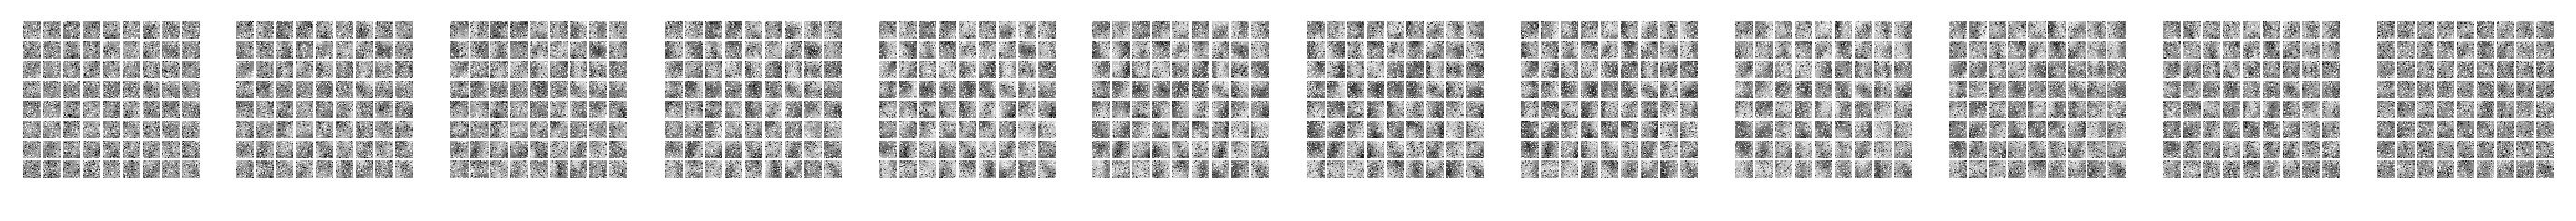

*************************************************Epoch 200/500 (mean time per epoch: 2.9s)


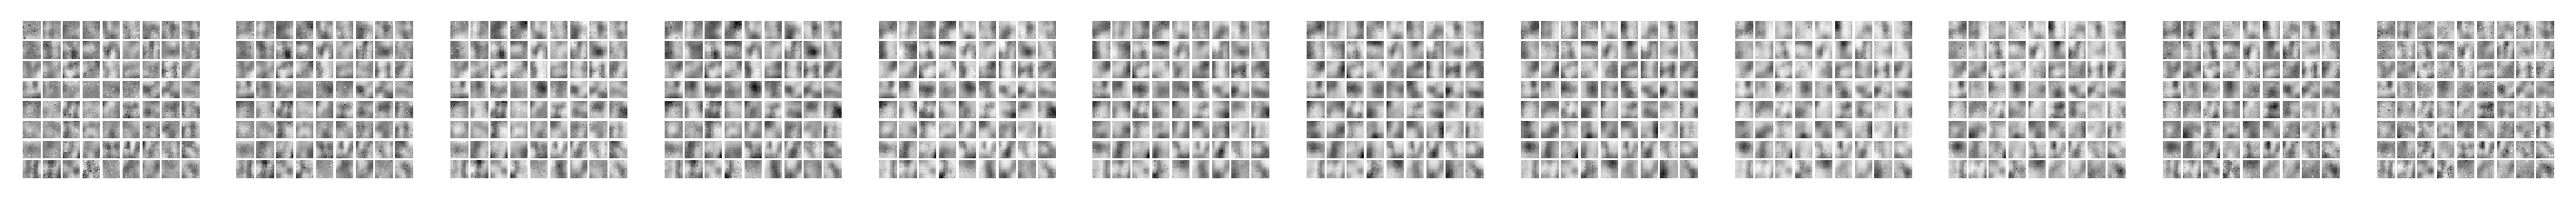

*************************************************Epoch 250/500 (mean time per epoch: 3.0s)


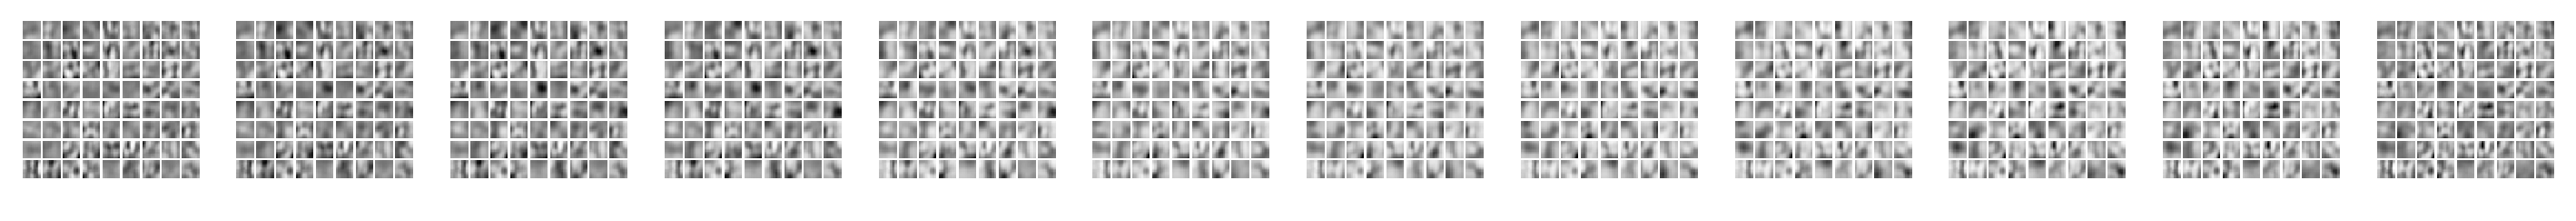

*************************************************Epoch 300/500 (mean time per epoch: 2.9s)


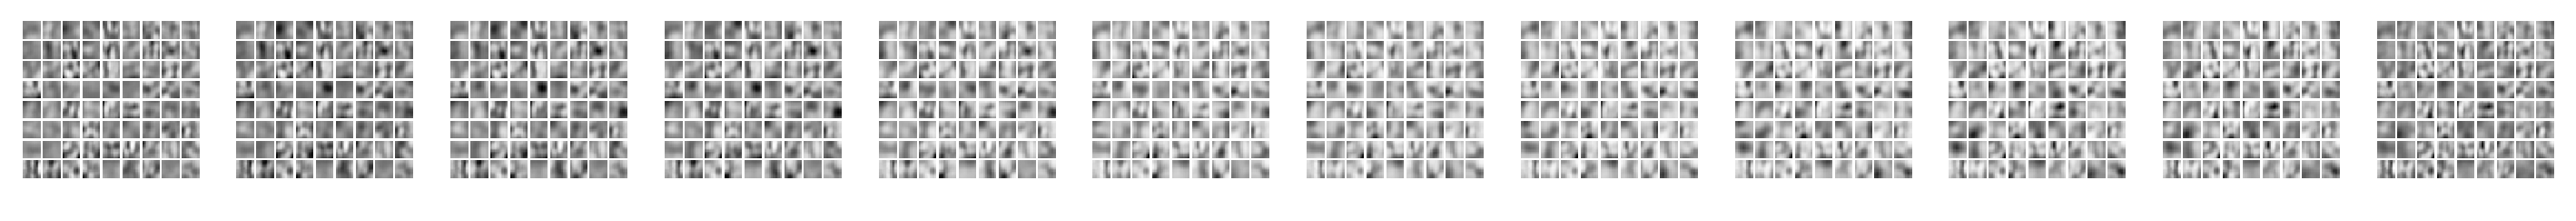

*************************************************Epoch 350/500 (mean time per epoch: 3.0s)


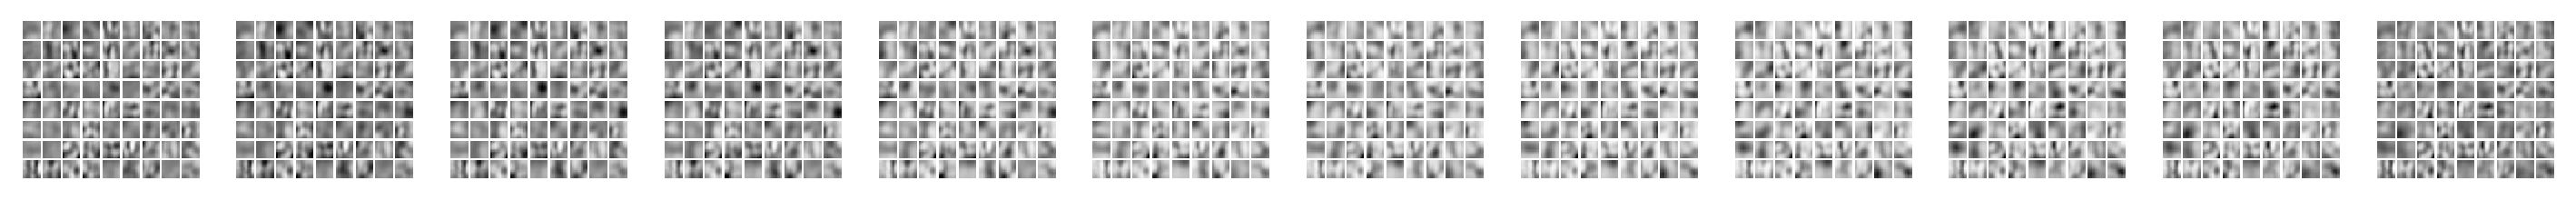

*************************

In [ ]:
imp.reload(mod)

for batch_size in batch_sizes:
    
    train_loader = mru.DataLoader(movie_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=8)
    
    for learning_rate in learning_rates:
        
        print(f'Learning Rate:{learning_rate}; batch size:{batch_size}')
        # our model
        model = mod.AEC(hidden_nodes, conv_width, pixel_patchsize, lambda_activation)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.cuda.is_available():
            model.cuda()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.5)#, momentum=learning_momentum)

        print_epocs = 10
        printing_modulo = num_epochs/print_epocs
        loss_history = []
        print(f'Training {num_epochs} Epochs. ',end="")

        for i in range(num_epochs):        
            start = time.time()
            times = []
            for movie in train_loader:
                movie = torch.unsqueeze(movie,1)
                movie = Variable(movie.float()).cuda()
                optimizer.zero_grad()
                acts = model.encode(movie)
                recon = model.decode(acts)
                loss = model.loss_func(movie, recon, acts)
                loss_history.append(loss.detach())
                loss.backward()
                optimizer.step()
                end = time.time()
                times.append(end-start)
            if(True):
                params = f'lr{learning_rate}_bs{batch_size}'
                if(i==0):
                    print(f'Estimated run time: {round(times[-1]*num_epochs/60,1)}mins.')
                elif((i+1)%printing_modulo==0):
                    print(f'Epoch {i+1}/{num_epochs} (mean time per epoch: {round(np.mean(times),1)}s)')
                    for name, parameter in model.named_parameters():
                        if(name=='tconv.weight_v'):
                            inw = np.array(parameter.squeeze().detach())
                            break
                    p = plu.plot_temporal_weights(inw)
                    plt.savefig(f'{savefolder}inw_{params}_{round(i/num_epochs,2)}.png')
                    plt.show()
                else:
                    print('*',end='')

        loss_evolution = [np.float(loss.detach()) for loss in loss_history]
        p = plt.plot(loss_evolution)
        plt.savefig(f'{savefolder}loss_{params}.png')
        plt.clf()
        p = plt.plot(np.log(loss_evolution))
        plt.savefig(f'{savefolder}logloss_{params}.png')
        plt.clf()

        mp = model.parameters()
        bias = np.array(next(mp).detach())
        wnorm = next(mp)
        inw = np.array(next(mp).squeeze().detach())
        outw = np.array(next(mp).squeeze().detach())

        p = plu.plot_temporal_weights(inw)
        plt.savefig(f'{savefolder}inw_{params}.png')
        plt.clf()
        p = plu.plot_temporal_weights(outw)
        plt.savefig(f'{savefolder}outw_{params}.png')
        plt.clf()


        print('Done!')


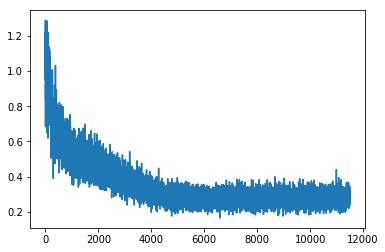

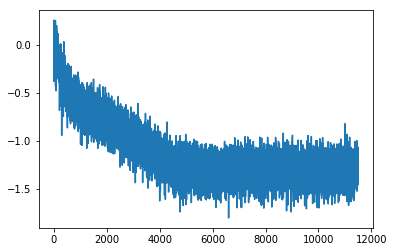

In [31]:
loss_evolution = [np.float(loss.detach()) for loss in loss_history]
plt.plot(loss_evolution)
plt.show()
plt.plot(np.log(loss_evolution))

In [ ]:
for name, parameter in model.named_parameters():
    print(name)
    if(name=='tconv.weight_v'):
        inw = np.array(parameter.squeeze().detach())
    elif(name=='tdeconv.weight'):
        outw = np.array(parameter.squeeze().detach())
    #elif(name=='tconv.weight_g'):
    #    print(np.shape(np.array(parameter.squeeze().detach())))

#print(inw.shape)
#print(bias.shape)
#print(wnorm.shape)
#print(outw.shape)
p = plu.plot_temporal_weights(inw)
p = plu.plot_temporal_weights(outw)

(array([  209.,  2273., 13429., 32271., 38462., 36597., 32575., 22217.,
         5721.,   566.]),
 array([-0.00456417, -0.00368705, -0.00280993, -0.0019328 , -0.00105568,
        -0.00017856,  0.00069856,  0.00157568,  0.00245281,  0.00332993,
         0.00420705]),
 <a list of 10 Patch objects>)

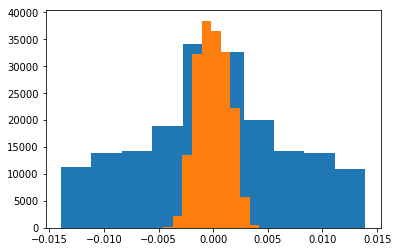

In [39]:
plt.hist(inw.flatten())
plt.hist(outw.flatten())

Movies:


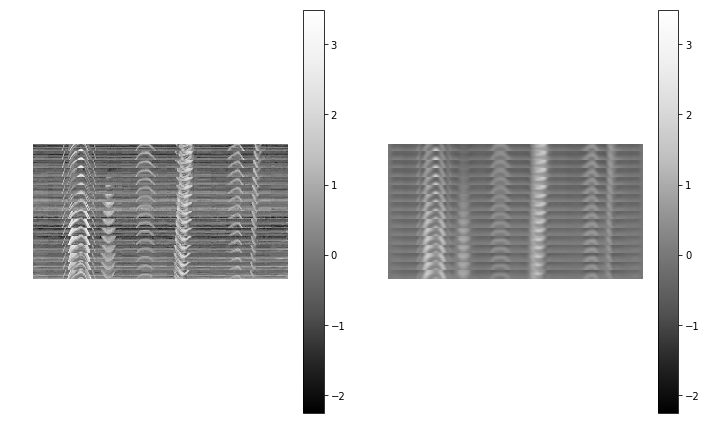

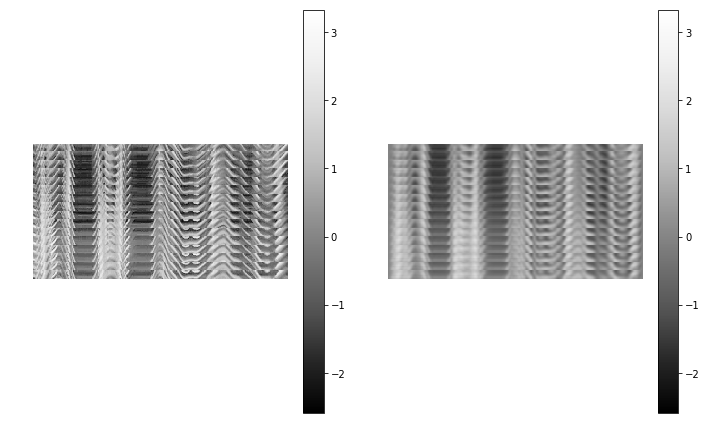

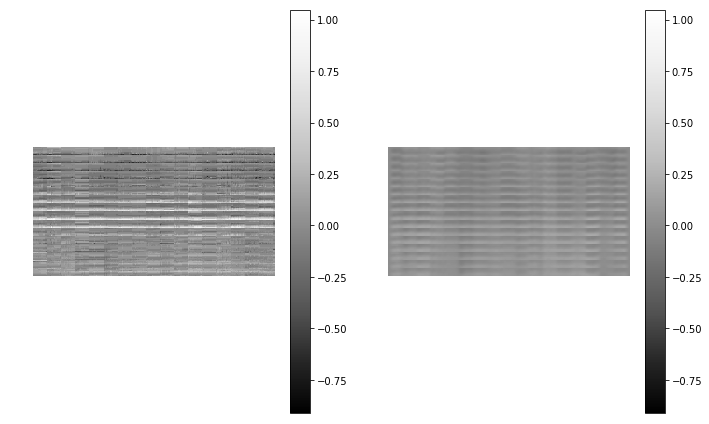

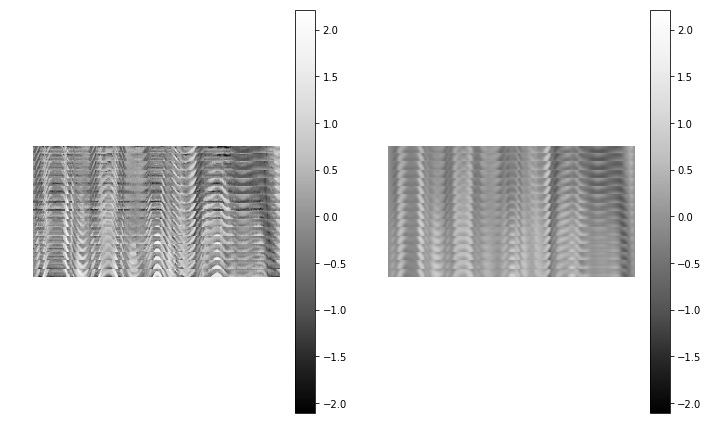

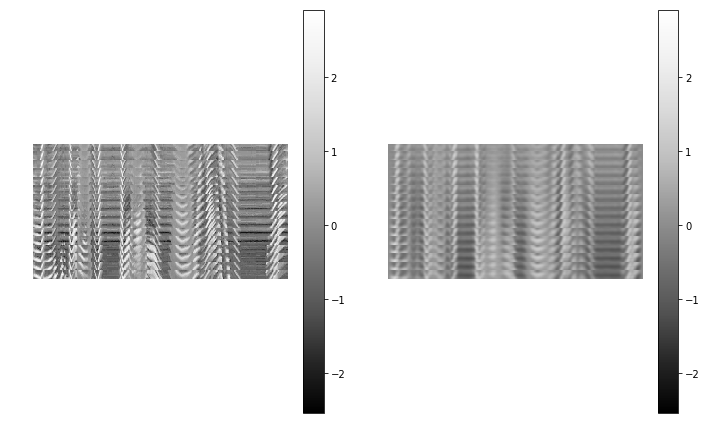

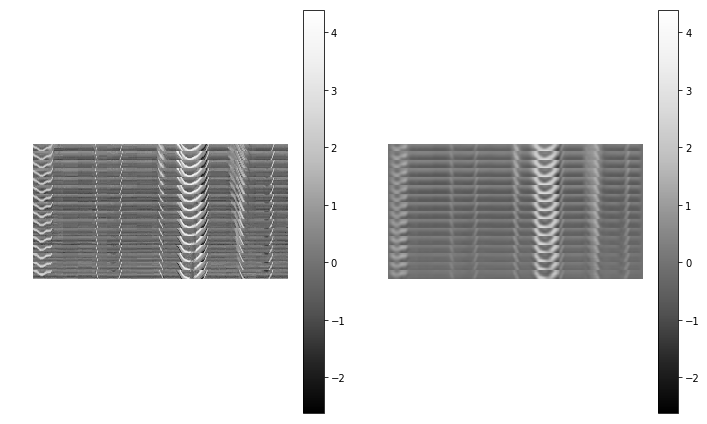

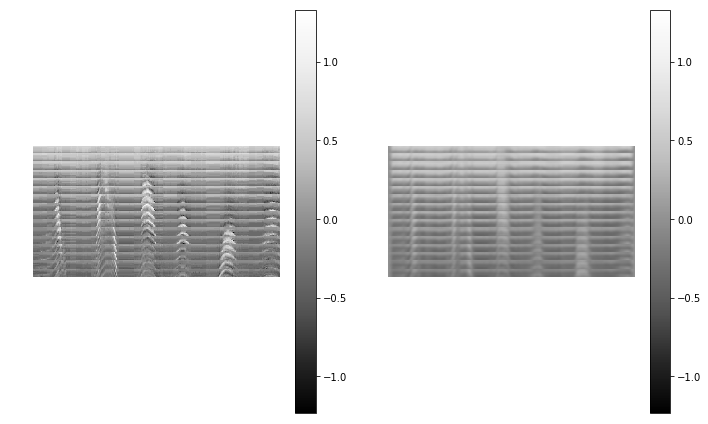

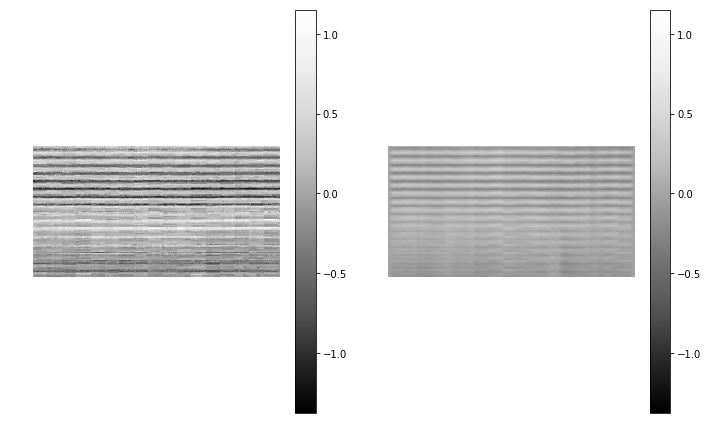

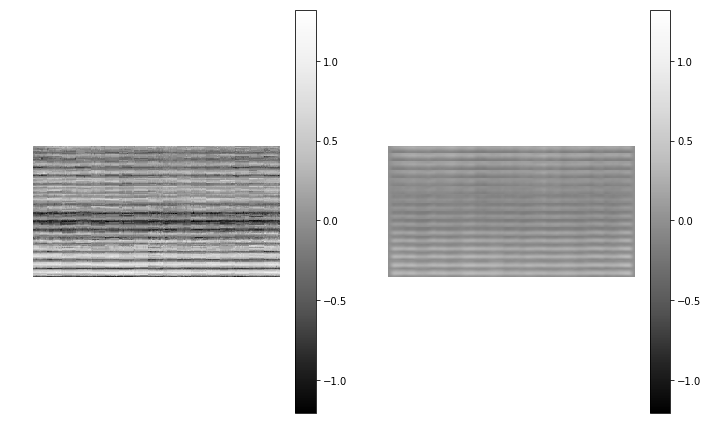

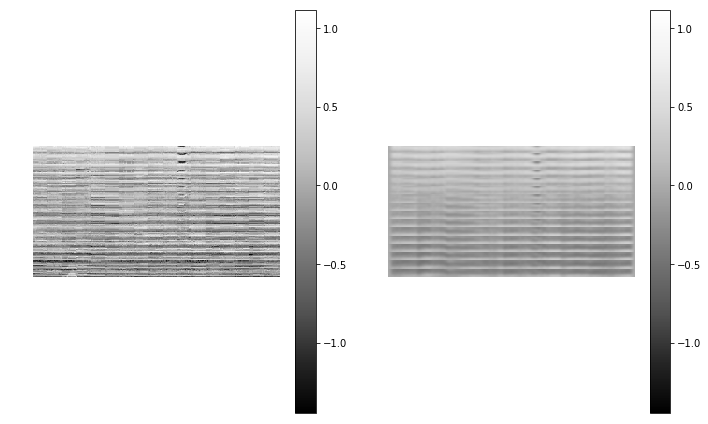

In [10]:
imp.reload(plu)
print('Movies:')
for i in range(10):
    plu.plot_movies_recons(np.squeeze(movie), np.squeeze(recon), i)
    #plt.colorbar()
plt.show()


(72, 12, 16, 16)
0.012217117
-0.012220311


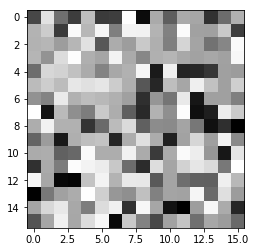

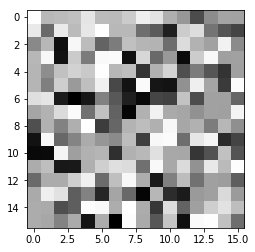

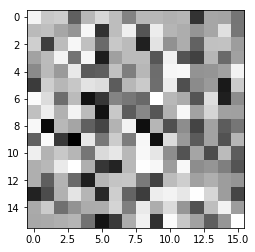

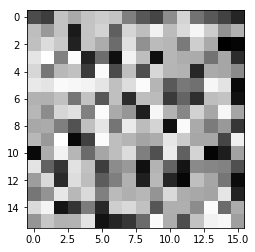

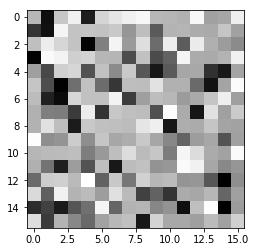

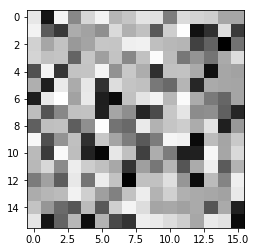

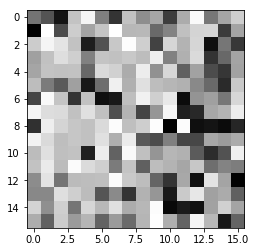

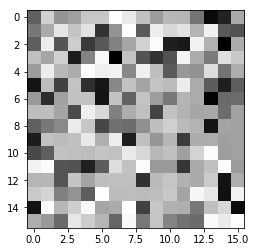

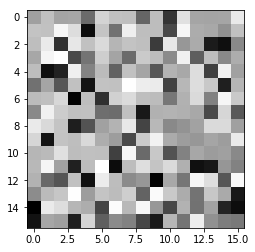

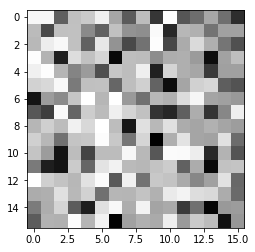

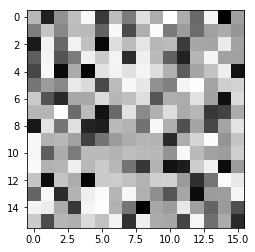

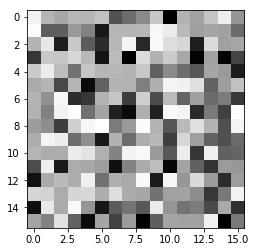

In [6]:
print(inw.shape)
print(np.max(inw))
print(np.min(inw))
for i in range(inw.shape[1]):
    plt.imshow(inw[20,i,:,:],cmap='Greys_r')
    plt.show()

In [ ]:
print(movie.shape)
m = movie[7,0,1,:,:]
plt.imshow(m)
print(m)

In [ ]:
movie.shape

In [ ]:
if(False):
    moreepochs = 2000
    print(f'Training for {moreepochs} more Epochs:')
    for i in range(moreepochs):
        start = time.time()
        times = []
        for movie in train_loader:
            movie = torch.unsqueeze(movie,1)
            #print(movie.size())
            movie = Variable(movie.float()).cuda()
            optimizer.zero_grad()
            acts = model.encode(movie)
            recon = model.decode(acts)
            loss = loss_func(movie, recon, acts)
            loss_history.append(loss.detach())
            loss.backward()
            optimizer.step()
            end=time.time()
            times.append(end-start)
            
        if((i+1)%printing_modulo==0):
            print(f'{i+1}th Epoch (mean time per epoch: {round(np.mean(times))}s)')
        else:
            print('*',end='')

    print('Done!')

In [ ]:
def visualize_aec():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(train_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.encode(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Recon Images')


visualize_aec()
plt.ioff()
plt.show()

In [ ]:
torchvision.utils.make_grid(input_tensor)

In [ ]:
# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
plt.ion()   # continuously plot

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

    
    
for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
    

In [ ]:
model = AEC()
if torch.cuda.is_available():
    model.cuda()